#  Social Network Project

Social networks play a crucial role in connecting people and communities online, and their analysis provides valuable insights into the underlying structures, dynamics, and behaviors that shape human interactions in online environments. <br>
In this project we will focus on the **Co-occurrence network** where ***nodes are hashtags***, and ***edges are videos*** in which two hashtags co-occur. We will be analysing data from **Youtube**.

We start by importing the needed libraries:

In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest, ks_2samp
%matplotlib inline
!pip install powerlaw
import powerlaw
from googleapiclient.discovery import build
import re
import gdown
import io
import random
import json
import os

##Co-occurrence network: construction

In this network, **nodes are hashtags**, and **edges are videos** in which two hashtags co-occur. We will be tracking hashtags on **Youtube** (https://youtube.com).

So firstly, let us connect to the google API and retrieve videos. I start from a simple hashtag, then I collect more from the results. We need at least a 1000 hashtags.

In [ ]:
def VidsFromTag(hashtag, max_results = 100):

    #Video query from April 2024 until currently
    google_api_key = 'key_id_here'
    youtube = build('youtube', 'v3', developerKey=google_api_key)
    request = youtube.search().list(
        q=hashtag,
        part='snippet',
        maxResults=max_results,
        publishedAfter='2024-04-01T00:00:00Z'
        )
    response = request.execute()

    #Get video ids
    video_ids = [item['id']['videoId'] for item in response['items'] if 'videoId' in item['id']]

    #Retrieve videos
    video_query_request = youtube.videos().list(
        part='snippet,statistics,contentDetails',
        id=','.join(video_ids)
    )
    video_query_response = video_query_request.execute()

    #Print query results
    videos = []
    hashtags = []
    for video in video_query_response['items']:
        try:
            vid_description = video['snippet']['description']
            vid_info = {
                'id': video['id'],
                'title':video['snippet']['title'],
                'description': vid_description,
                'views':int(video['statistics']['viewCount']),
                'publishedAt': video['snippet']['publishedAt'],
                'hashtags': [tag.lower() for tag in re.findall(r'#\w+',vid_description)]
            }
            #print(f'Video id: {vid_info["id"]}, hashtags: {vid_info["hashtags"]}')
            videos.append(vid_info)
            hashtags.extend([tag.lower() for tag in vid_info['hashtags']])
        except Exception as e:
            print(f'Error retrieving a video: {e}')
    return videos, list(set(hashtags))

Let's test it:

In [ ]:
#vids, hashtags = VidsFromTag('#crypto')
#print(hashtags)
#print(len(hashtags))

Let's get 1000 hashtags or more with videos

In [ ]:
def collect_tags():
    popular_tags = [
        '#crypto',
        '#blockchain',
        '#bitcoin',
        '#btc',
        '#bitcoinnews',
        '#ethereum',
        '#eth',
        '#solana',
        '#bnb',
        '#xrp',
        '#ripple',
        '#dogecoin',
        '#shibainu',
        '#cardano',
        '#defi',
        '#altcoin',
        '#cryptocurrency',
        '#cryptotrading',
        '#cryptoinvestment',
        '#cryptonews',
        '#cryptocurrencynews',
        '#cryptolife',
        '#cryptoart',
        '#cryptotwitter',
        '#cryptoverse',
        '#cryptoexchange',
        '#cryptomining',
        '#cryptomarket',
        '#cryptocurrencytradingplatform',
        '#cryptocurrencysolution',
        '#cryptocurrencytraders',
        '#cryptocurrency_for_dummies',
        '#cryptocurrencyusa',
        '#cryptocurrencymalaysia',
        '#cryptocurrencytakingover',
        '#cryptocurrencybali',
        '#cryptocurrencyinvestors',
        '#cryptocurrencyindex',
        '#cryptocurrencyattorney',
        '#cryptocurrencynews',
        '#cryptocurrenciesinvestor',
        '#cryptocurrenciesnews',
        '#bestcryptocurrencies',
        '#tradingcryptocurrencies',
        '#pricepredictions',
        '#halving',
        '#spotetf'
    ]

    tags, vids = [], []
    while(len(tags)<1000):
        rdm_tag = random.choice(popular_tags)
        n_vids, n_tags = VidsFromTag(rdm_tag)
        tags.extend(n_tags)
        tags = list(set(tags))
        vids.extend(n_vids)

    vids = sorted(vids,key=lambda x: x['views'],reverse=True)
    return tags, vids

Now, let's build and save the graph:

In [ ]:
def build_vids_graph(tags, vids):
    with open('vids.json','w') as file:
        json.dump(vids, file, indent=4)
    G = nx.Graph()
    #G.add_nodes_from([(i, {'tag':tag}) for i,tag in enumerate(tags)])
    G.add_nodes_from(tags)
    for vid in vids:
        if vid:
            edges_list = [(u,v,{'video_id':vid['id']}) for u in vid['hashtags'] for v in vid['hashtags'] if u!=v and not G.has_edge(u,v)]
            G.add_edges_from(edges_list)

    nx.write_gml(G,'vids_graph.gml')
    return G

Process execution (daily search quota is limited):

In [ ]:
#tags, vids = collect_tags()
#vids_graph = build_vids_graph(tags, vids)

## Network Analysis

Firstly, we load the previously-built graph. It has `1044 nodes` and `36234 edges`:

In [ ]:
#Saved network
#From 01/04/2024 to 04/05/2024
url_a = 'https://drive.google.com/file/d/1_3L35Lf7eNiJijaHnftEj8w5OA0HojTA/view?usp=sharing'
url_input = f'https://drive.google.com/uc?id={url_a.split("/")[-2]}'
output = io.BytesIO()
gdown.download(url_input, output, quiet=False)
output.seek(0)
graph_content = output.read().decode('utf-8')
G  = nx.parse_gml(graph_content)
print(G)
print(G.nodes(data=True))
print(G.edges(data=True))

Or use the newly constructed network if it exists:

In [ ]:
#New network
if os.path.exists('vids_graph.gml'):
    G = nx.read_gml('vids_graph.gml')

In [ ]:
print(G)
print(G.nodes(data=True))
print(G.edges(data=True))

This graph is `homogenous`, `unweighted`, and `undirected`.

### Visualisation:

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 120813 (\N{MATHEMATICAL SANS-SERIF BOLD DIGIT ONE}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 120813 (\N{MATHEMATICAL SANS-SERIF BOLD DIGIT ONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


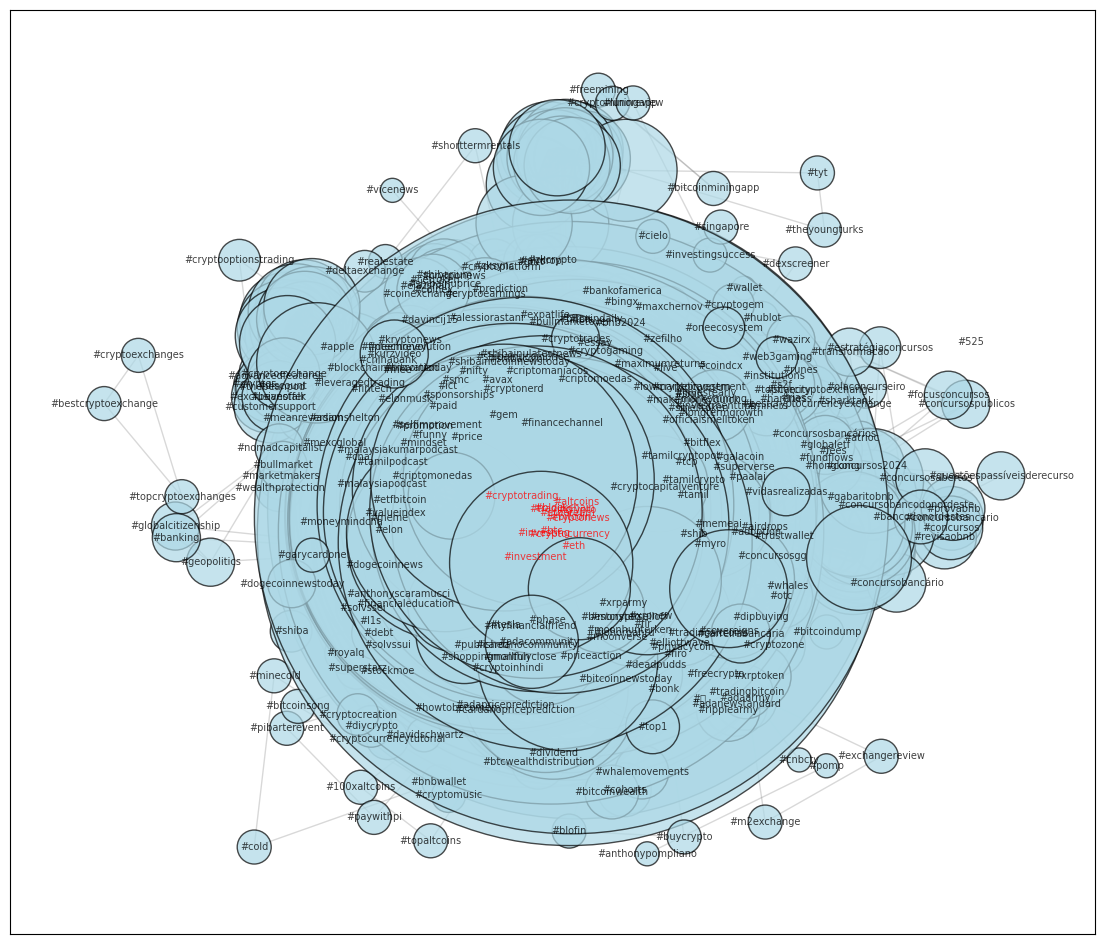

In [ ]:
sizes = [G.degree[node] * 300 for node in G.nodes]
layout = nx.spring_layout(G, k=0.2)
#layout = nx.kamada_kawai_layout(G)
plt.figure(figsize=(14, 12))
nx.draw_networkx_nodes(G, pos=layout, node_size=sizes, node_color='lightblue', edgecolors='black', alpha=0.7)
nx.draw_networkx_edges(G, pos=layout, alpha=0.3, edge_color='gray')

txt_labels = {n:n for n in G.nodes if G.degree[n]<=10 or G.degree[n]>=350}
for n in txt_labels:
    if G.degree[n]>=300:
        color = 'red'
    elif G.degree[n]<=10:
        color = 'black'
    nx.draw_networkx_labels(G, pos=layout,
                            labels={n:txt_labels[n]},
                            font_size=7,
                            font_color=color,
                            alpha=0.75)

Since the graph is too big to be shown fully, this function will show a subgraph of nodes with degrees above a defined limit:

In [ ]:
def Visualise_Graph(graph, node_sizes_factor, limit, size_factor, title=''):
    #Spring layout
    #Show nodes with degree above a certain limit
    high_nodes = {node: node for node in graph.nodes if node_sizes_factor[node] > limit}
    sub_graph = graph.subgraph(high_nodes.keys())

    sizes = [node_sizes_factor[node]*size_factor for node in sub_graph.nodes]
    layout = nx.spring_layout(sub_graph, k=0.2)
    #layout = nx.kamada_kawai_layout(sub_graph)

    plt.figure(figsize=(14, 12))
    nx.draw_networkx_nodes(sub_graph, pos=layout, node_size=sizes, node_color='lightblue', edgecolors='black', alpha=0.7)
    nx.draw_networkx_edges(sub_graph, pos=layout, alpha=0.3, edge_color='gray')

    #Show labels only for high degree nodes
    nx.draw_networkx_labels(sub_graph, pos=layout, labels=high_nodes, font_size=10, font_color='black')
    plt.title(f'Graph visualisation of top 5% tags (nodes) and videos (links): {title}')
    plt.show()

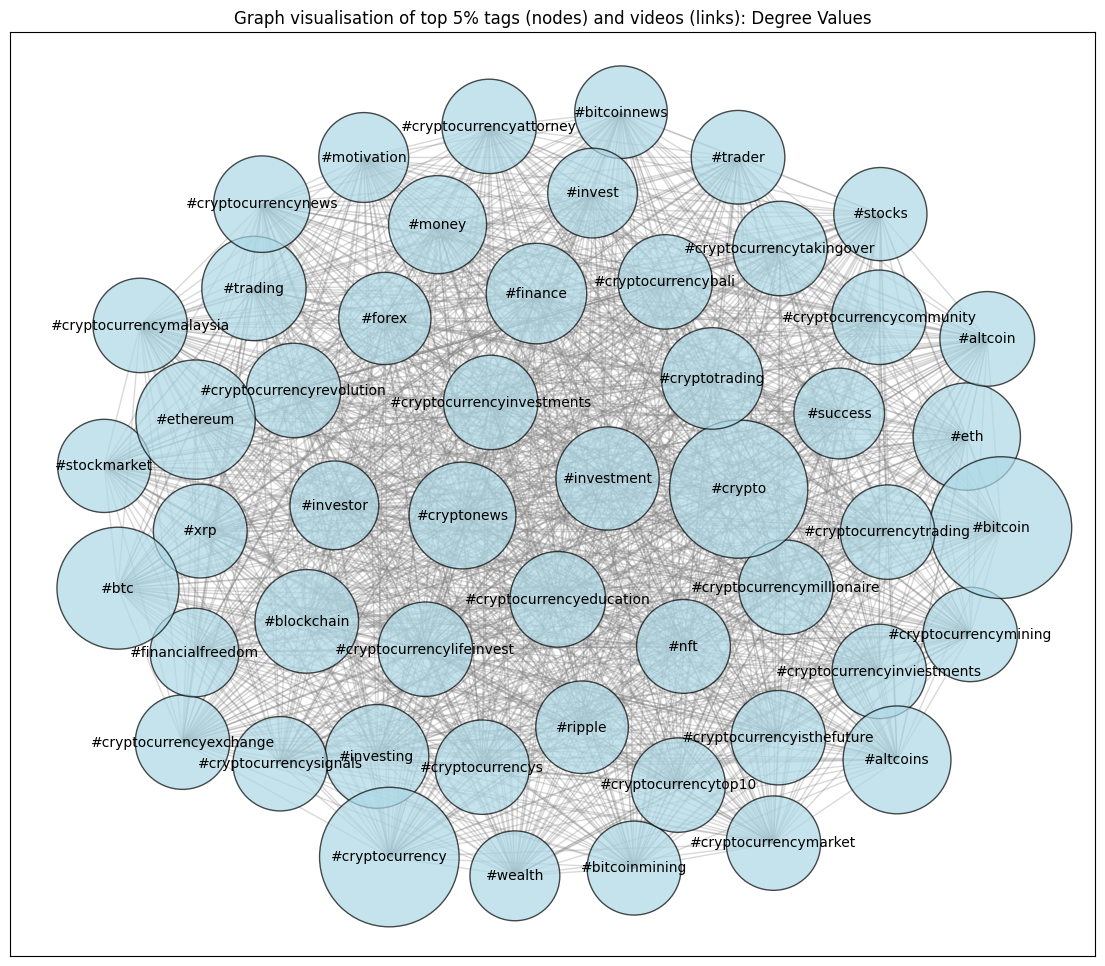

In [ ]:
#degree_limit = sample_highest_centralities(net_stats['degree_distribution'],0.05)
Visualise_Graph(G, {node:G.degree[node] for node in G.nodes}, limit=268, size_factor=15, title='Degree Values')

We can see in the above sub-graph the top 5% of tags or nodes with the highest degrees (most popular) present in our video graph, with sizes proportional to their degrees.

###Characteristics:

In [ ]:
def graph_stats(G):
    #Compute metrics
    net_stats = {}
    largest_cc = G.subgraph(max(nx.connected_components(G))).copy()
    net_stats['n_nodes'] = len(G.nodes)
    net_stats['radius'] = nx.radius(largest_cc)
    net_stats['diameter'] = nx.diameter(largest_cc)
    net_stats['average_clustering'] = nx.average_clustering(G)
    net_stats['average_path_length'] = nx.average_shortest_path_length(largest_cc)
    net_stats['number_cc'] = nx.number_connected_components(G)
    net_stats['largest_cc'] = largest_cc
    net_stats['degree_distribution'] = sorted([degree for node, degree in G.degree()], reverse=True)
    net_stats['degree_centrality'] = nx.degree_centrality(G)
    net_stats['betweenness_centrality'] = nx.betweenness_centrality(G)
    net_stats['closeness_centrality'] = nx.closeness_centrality(G)
    net_stats['eigenvector_centrality'] = nx.eigenvector_centrality(G)
    #A = nx.adjacency_matrix(G).toarray()
    #eig_values, _ = np.linalg.eig(A)
    #stats['katz_centrality'] = nx.katz_centrality(G, alpha=1/max(eig_values)-0.01)
    return net_stats

In [ ]:
net_stats = graph_stats(G)
basic_metrics = ['n_nodes','radius','diameter','average_clustering','average_path_length','number_cc']

In [ ]:
', '.join([f'{key}: {net_stats[key]}' for key in basic_metrics])

'n_nodes: 1044, radius: 3, diameter: 6, average_clustering: 0.9067768008854319, average_path_length: 2.223979308232465, number_cc: 7'

Interpreting some the statistics:
* A `radius` of 3 and a `diameter` of 6 suggest a moderatly-sized network that has a relatively compact structure, where nodes are not too far from each other.
* `Clustering coefficient` measures the degree to which nodes in a network tend to cluster together. This high very high average clustering coefficient (close to 1) suggests that nodes in this network tend to form compact groups or clusters.
* A short `average-path` also suggests a compact network where nodes are relatively close to each other, facilitating efficient communication and information flow.
* There are `7 connected components` in this network. Connected components are groups of nodes that are interconnected but isolated from the rest of the network. This suggests that the network consists of several distinct subnetworks or modules.

Now to see the degree distribution and compare it to power law distribution:

####Degree distribution

In [ ]:
print(net_stats['degree_distribution'])

[694, 673, 660, 514, 492, 402, 398, 394, 376, 372, 371, 368, 356, 349, 332, 322, 316, 310, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 308, 305, 304, 304, 303, 300, 300, 296, 296, 294, 284, 279, 279, 278, 272, 272, 268, 268, 267, 267, 267, 264, 264, 264, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 263, 262, 262, 259, 256, 253, 253, 253, 253, 250, 246, 238, 238, 237, 233, 230, 227, 226, 224, 218, 218, 206, 200, 196, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 191, 167, 149, 146, 143, 143, 138, 134, 128,

In [ ]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


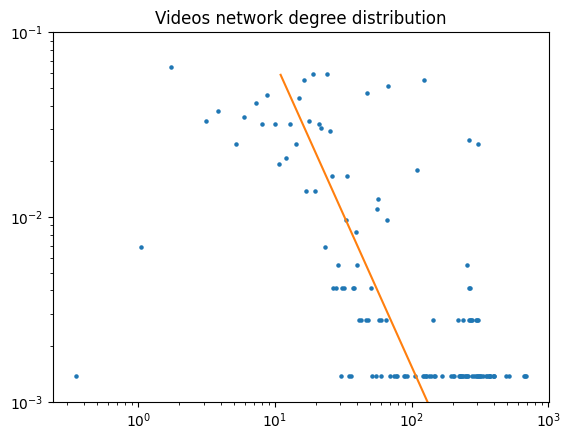

Estimated alpha = 1.6457849021489346
Estimated xmin = 11.0
KS distance: 0.10346615129089276
KS test: statistic=0.7413793103448276, p-value=0.0


In [ ]:
degree_sequence = np.array(net_stats['degree_distribution'])
hist, bin_edges = np.histogram(degree_sequence, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('Videos network degree distribution')

fit = powerlaw.Fit(degree_sequence, discrete=True)
hat_alpha = fit.power_law.alpha
hat_x_min = fit.power_law.xmin
x_space = np.linspace(hat_x_min, degree_sequence.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min),
         label='Estimated PDF', c='tab:orange')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.001, 0.1)
plt.show()

print(f'Estimated alpha = {hat_alpha}')
print(f'Estimated xmin = {hat_x_min}')
print(f'KS distance: {fit.power_law.KS()}')
ks_statistic, ks_p_value = kstest(degree_sequence, 'powerlaw', args=(hat_alpha, hat_x_min))
print(f'KS test: statistic={ks_statistic}, p-value={ks_p_value}')

We can see that the degree distribution of the graph doesen't seem to follow a powerlaw distribution, despite the data being scattered in powerlaw-like form. Also, the KS test affirms this with a high statistic and 0 p-value.<br>
So, we can say that this network is not entirely a scale-free network, and might not behave like one.

####Random graph similarity

Let's try and see the similarity of this graph to random graphs. I will be comparing it with 4 random network models: `Erdos-Renyi Model`, `Barabasi-Albert Model`, `Watts-Strogatz model`, and the `configuration model`. As metric we will use this function to compare some basic metrics (1 being complete similarity of the used metrics, 0 no similarity):

In [ ]:
def evaluate(random_G):
    random_model_stats = graph_stats(random_G)
    #KS distance: 0 similar, 1 different
    ks_stat, p_value = ks_2samp(net_stats['degree_distribution'],random_model_stats['degree_distribution'])
    #Compare  scores
    s = ks_stat
    for metric in basic_metrics[1:]:
        s += abs(net_stats[metric]-random_model_stats[metric])/net_stats[metric]

    return 1-s/(len(basic_metrics))

In [ ]:
n = len(G.nodes)
E = len(G.edges)
#Approximate edge probability for G
p = E/(n*(n-1)/2)
G1 = nx.erdos_renyi_graph(n, p)
#A heuristic value, average degree divised by 2
m = int(E/n)
G2 = nx.barabasi_albert_graph(n, m)
G3 = nx.watts_strogatz_graph(n, 2*int(E/n), 0.1)
G4 = nx.Graph(nx.configuration_model([degree for node, degree in G.degree()]))
#Other manual values
G1_a = nx.erdos_renyi_graph(n, 0.05)
G2_a = nx.barabasi_albert_graph(n, 10)

print(f'Erdos Renyi: {evaluate(G1)}')
print(f'Barabasi Albert: {evaluate(G2)}')
print(f'Watts Strogatz: {evaluate(G3)}')
print(f'Configuration model: {evaluate(G4)}')
#####
print(f'Erdos Renyi with manual values: {evaluate(G1_a)}')
print(f'Barabasi Albert with manual values: {evaluate(G2_a)}')

Erdos Renyi: 0.4298738559955958
Barabasi Albert: 0.45540272436090523
Watts Strogatz: 0.5859879133715362
Configuration model: 0.6978362484044953
Erdos Renyi with manual values: 0.4990582468628909
Barabasi Albert with manual values: 0.5699168727333304


We notice that the values manually chosen through trial and error, by deviating from the theoretical values, give in some cases slightly better results than the theoretical ones (their counterparts) that should approximate our graph best. This could be due to the accuracy of the metric we're using as it is not comparing the graphs in the best way possible.<br>
We can say that our graph presents a degree of randomness but is not a completely random one. And looking at the results, we can say that the configuration model seems to approximate our graph best amongst the tested random models, which was expected since it takes the whole degree distribution as input (Watts-Strogatz gives good results as well).

#### Centralities

Let's analyse the centralities. First we draw the graph (or the subgraph of certain nodes) and observe how centrality values are distributed amongs nodes.<br>
Firstly, we make a function to give us the best 5% centralities

In [ ]:
def sample_highest_centralities(data, p):
    data_sorted = sorted(data, reverse=True)
    return data_sorted[int(len(data_sorted)*p)]

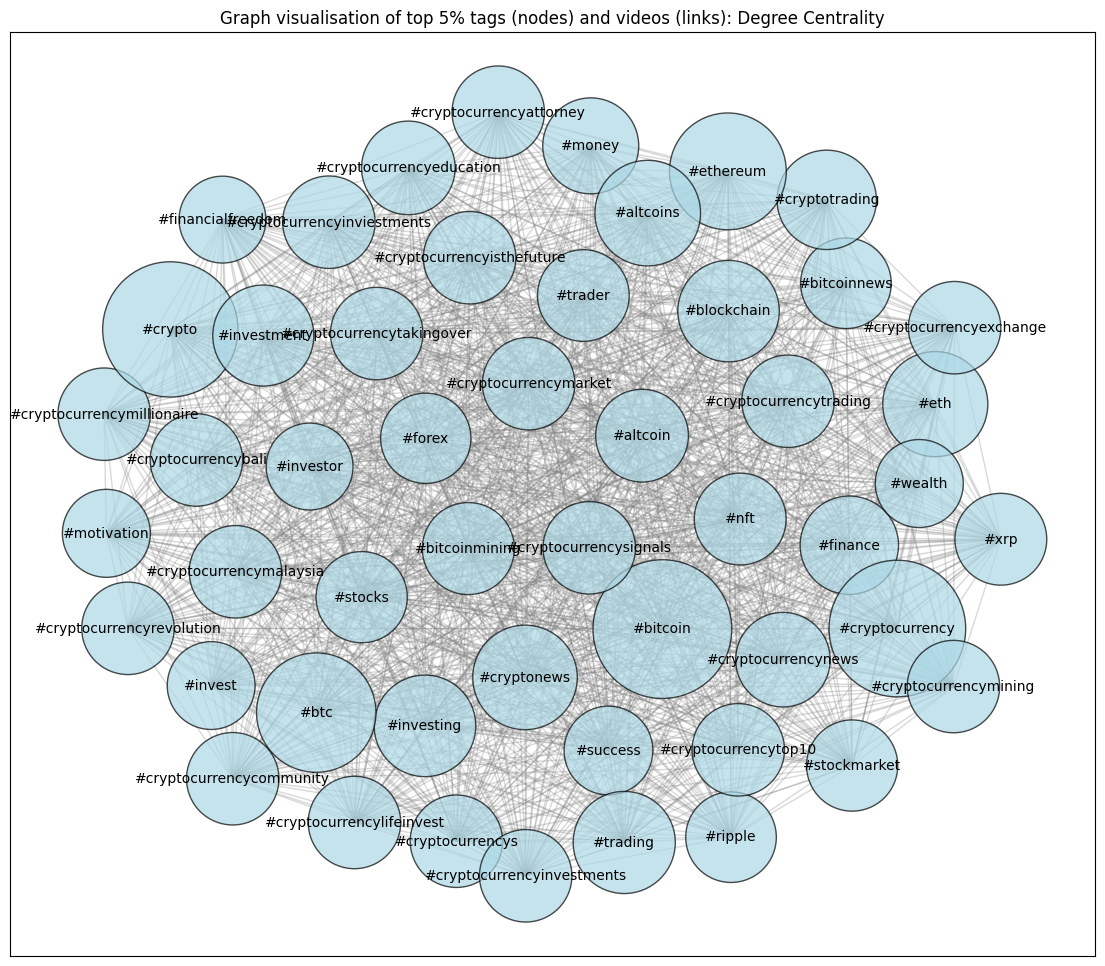

In [ ]:
limit_deg_cent = sample_highest_centralities(net_stats['degree_centrality'].values(),0.05)
Visualise_Graph(G, net_stats['degree_centrality'],limit = limit_deg_cent, size_factor=15000, title='Degree Centrality')

Nodes with higher degree centrality have more connections to other nodes in the network, often considered highly connected or central hubs. So here, larger nodes have more connections with other nodes.<br>
The subgraph above has a very similar pattern to the one in visualisation section where nodes are proportional in size to their degree value.

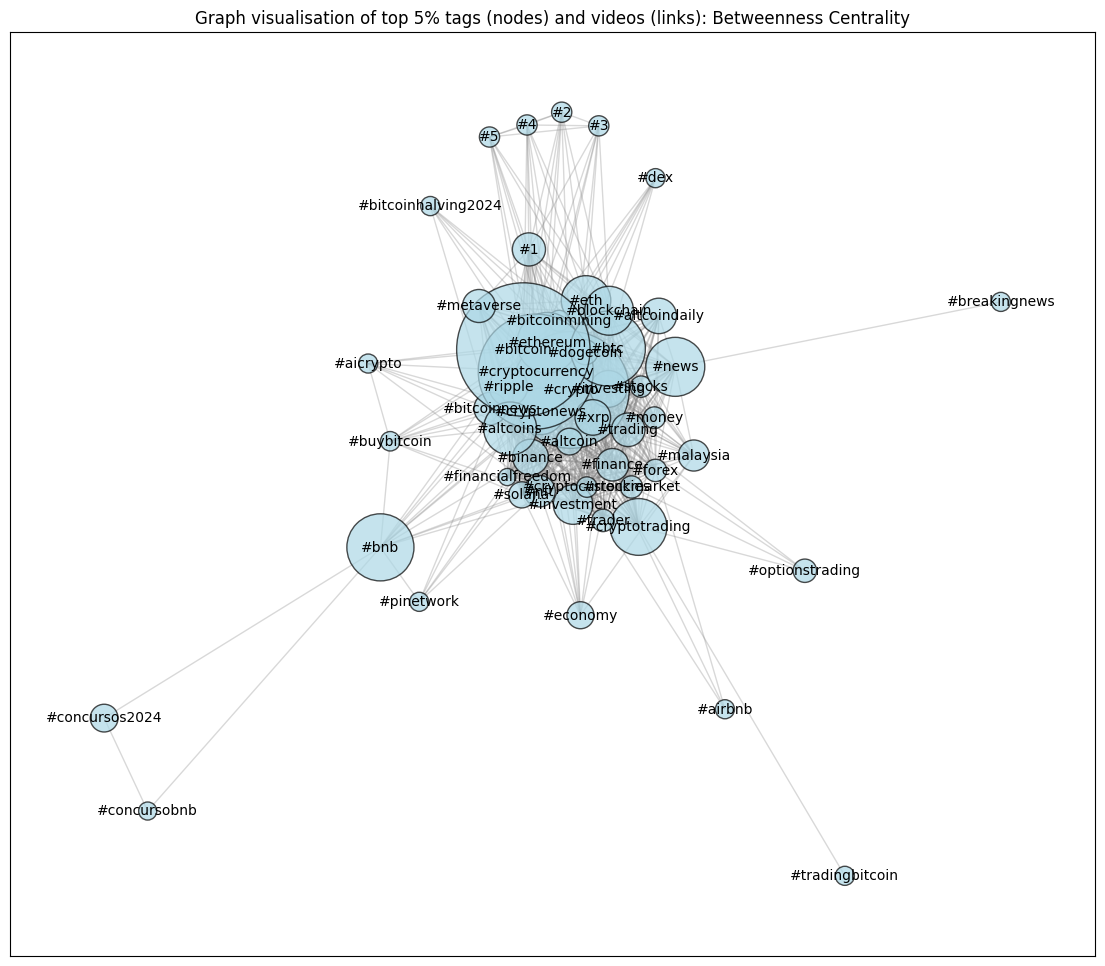

In [ ]:
limit_bet_cent = sample_highest_centralities(net_stats['betweenness_centrality'].values(),0.05)
Visualise_Graph(G, net_stats['betweenness_centrality'],limit = limit_bet_cent, size_factor=50000, title='Betweenness Centrality')

Nodes with higher betweenness centrality act as bridges or intermediaries in the network, controlling the flow of information between different clusters or groups of nodes. Larger nodes in this case are more critical for connecting different parts of the network, even if they themselves are not highly connected.<br>
In the above subgraph, we can see familiar tags from previous graphs (degree proportional) such as `#btc` or `#bitcoin`, but we also see some new tags that weren't amongst the most connected such as `#bnb` or `#binance`.

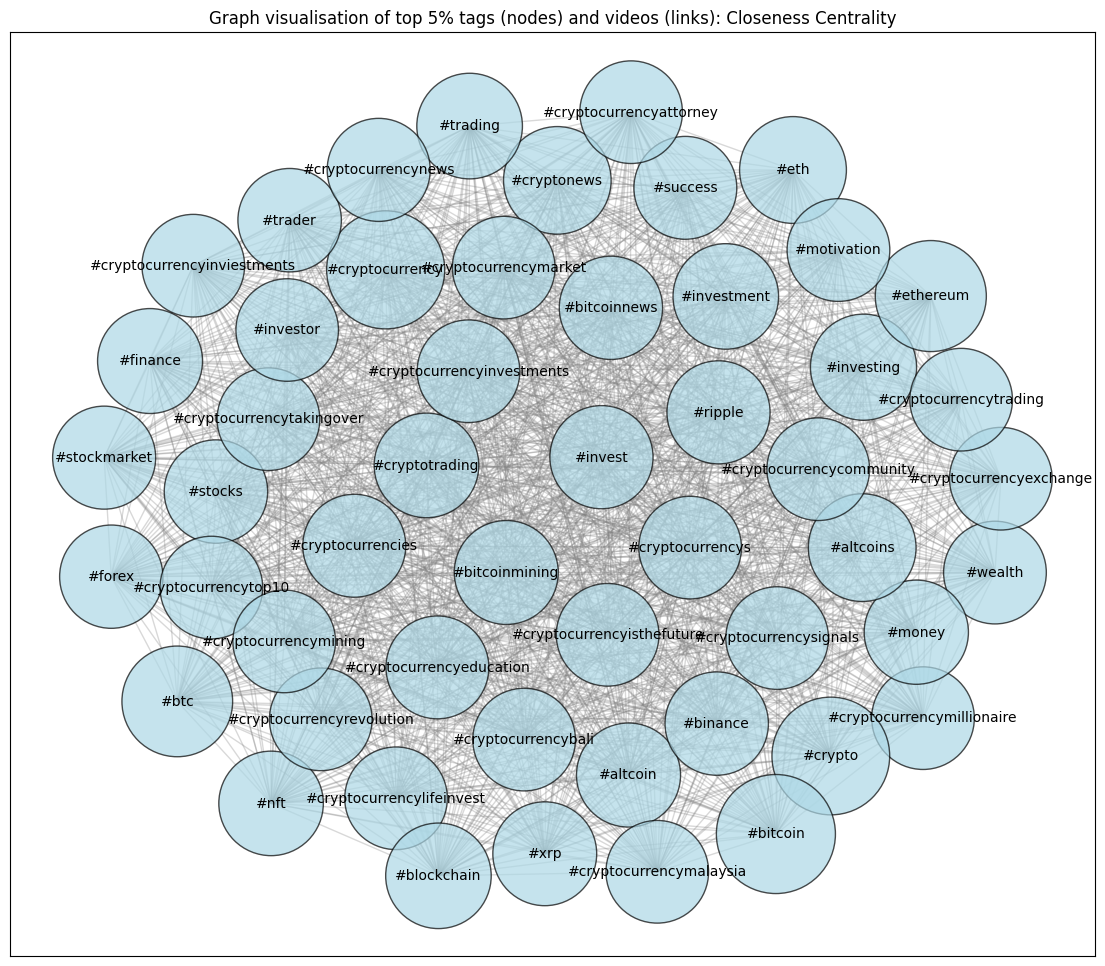

In [ ]:
limit_cls_cent = sample_highest_centralities(net_stats['closeness_centrality'].values(),0.05)
Visualise_Graph(G, net_stats['closeness_centrality'],limit = limit_cls_cent, size_factor=10000, title='Closeness Centrality')

Nodes with higher closeness centrality are closer to all other nodes in terms of the shortest path distance, so here larger nodes could be considered centrally located within the network, minimizing the average distance to all other nodes.<br>
We can recognise some tags from the degree centrality graph (`#bitcoin`, `#ethereum`, `#blockchain`...), some others with degrees not as high (like `#binance`). But mostly, we recognise tags with high degree centrality here.

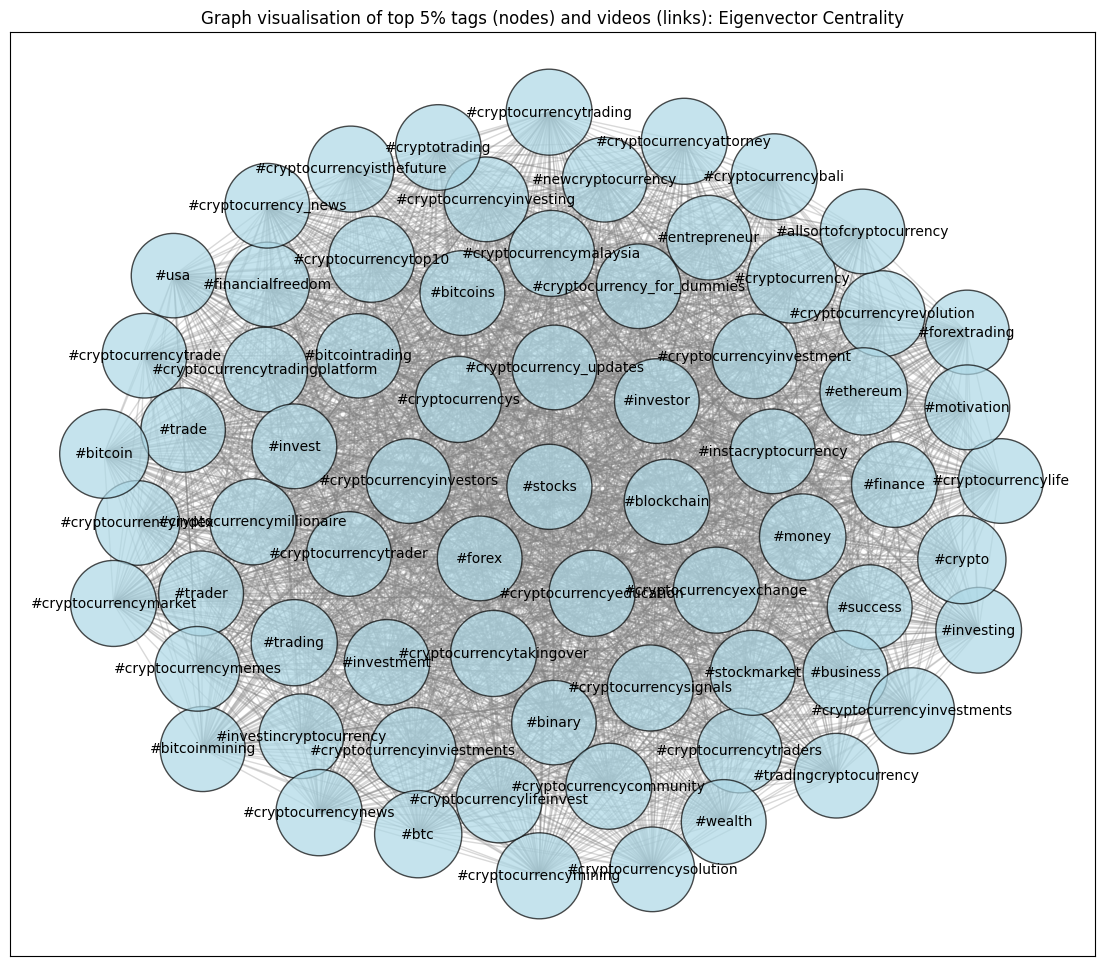

In [ ]:
limit_eig_cent = sample_highest_centralities(net_stats['eigenvector_centrality'].values(),0.07)
Visualise_Graph(G, net_stats['eigenvector_centrality'],limit = limit_eig_cent, size_factor=50000, title='Eigenvector Centrality')

Nodes with higher eigenvector centralitiy values are considered influential in the network, and not just because of degree value and connections, but also because they could be connected to other highly influential nodes.<br>
This subgraph somewhat highlights a hierarchy of influence within the network. We can immediatley recognise the important tags from previous visualisations with different centralities, but also we can notice some other newly immerged tags like `#usa`, or `cryptocurrency_updates`, or `cryptocurrency_for_dummies`, or `#instacryptocurrency`. They might not be in many videos like the other popular tags, but when they are present they are mainly around some popular tags (popular, or with many connections).

#### Assortative mixing

Since the nodes in our graph don't have attributes, we'll be only assessing `assortative mixing by degree`: it assesses the tendency of nodes to connect with other nodes of similar or dissimilar degree. This metric can provide insights into the structural properties of our video graph.<br>
Let us see its value:

In [ ]:
degree_assortativity = nx.degree_assortativity_coefficient(G)
print("Degree Assortativity Coefficient:", degree_assortativity)

Degree Assortativity Coefficient: -0.07869720070816592


A degree assortativity coefficient of around 0 suggests our graph has neutral assortativity. This means it does not show a strong tendency towards either assortative mixing (nodes with similar degrees tending to connect) or disassortative mixing (nodes with dissimilar degrees tending to connect).

#### Clustering

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
A = nx.adjacency_matrix(G).todense()

First, `kmeans clustering`:

Text(0.5, 1.0, 'Silouhette method')

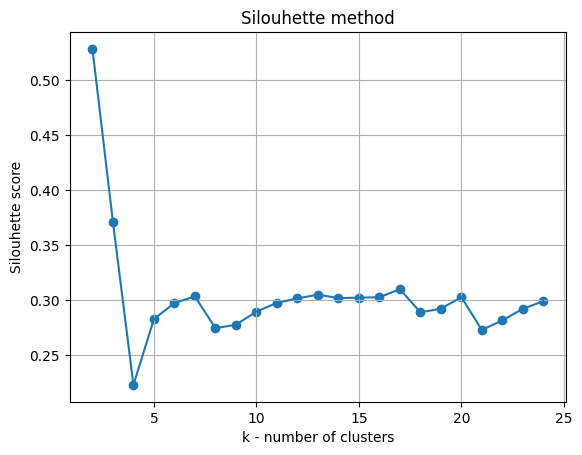

In [ ]:
silhouettes = []
inertias = []
for n in range(2,25):
    kmeans = KMeans(n_clusters=n, n_init=1, random_state=42)
    kmeans.fit(A)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(A,kmeans.labels_))
plt.scatter(range(2,25),silhouettes)
plt.plot(range(2,25),silhouettes)
plt.xlabel('k - number of clusters')
plt.ylabel('Silouhette score')
plt.grid(True)
plt.title('Silouhette method')

`2` seem to have the highest silhouette score, but I will choose another value with a high score, `7` for example since it seems more diverse.

In [ ]:
n_kmeans=7
kmeans = KMeans(n_clusters=n_kmeans, n_init=1, random_state=42)
kmeans.fit(A)
kmeans_labels = kmeans.labels_

In [ ]:
def draw_clusters(G,labels,n_,title_,attr='kmeans_cluster'):
    mapping = {node:i for i,node in enumerate(G.nodes)}
    cluster_dict = {node: labels[mapping[node]] for node in G.nodes}
    nx.set_node_attributes(G, cluster_dict, attr)
    colors = plt.cm.rainbow(np.linspace(0, 1, n_))
    sizes = [G.degree[node]*10 for node in G.nodes]
    layout = nx.spring_layout(G, k=0.2)
    #layout = nx.kamada_kawai_layout(G)

    plt.figure(figsize=(14, 12))
    for cluster, color in zip(range(n_), colors):
            nodes = [node for node, data in G.nodes(data=True) if data[attr] == cluster]
            nx.draw_networkx_nodes(G,
                                   layout,
                                   nodelist=nodes,
                                   node_color=[color],
                                   node_size=[sizes[mapping[node]] for node in nodes],
                                   label=f"Cluster {cluster}",
                                   edgecolors='black')

    nx.draw_networkx_edges(G, pos=layout, alpha=0.3, edge_color='gray')
    plt.title(title_)
    plt.show()

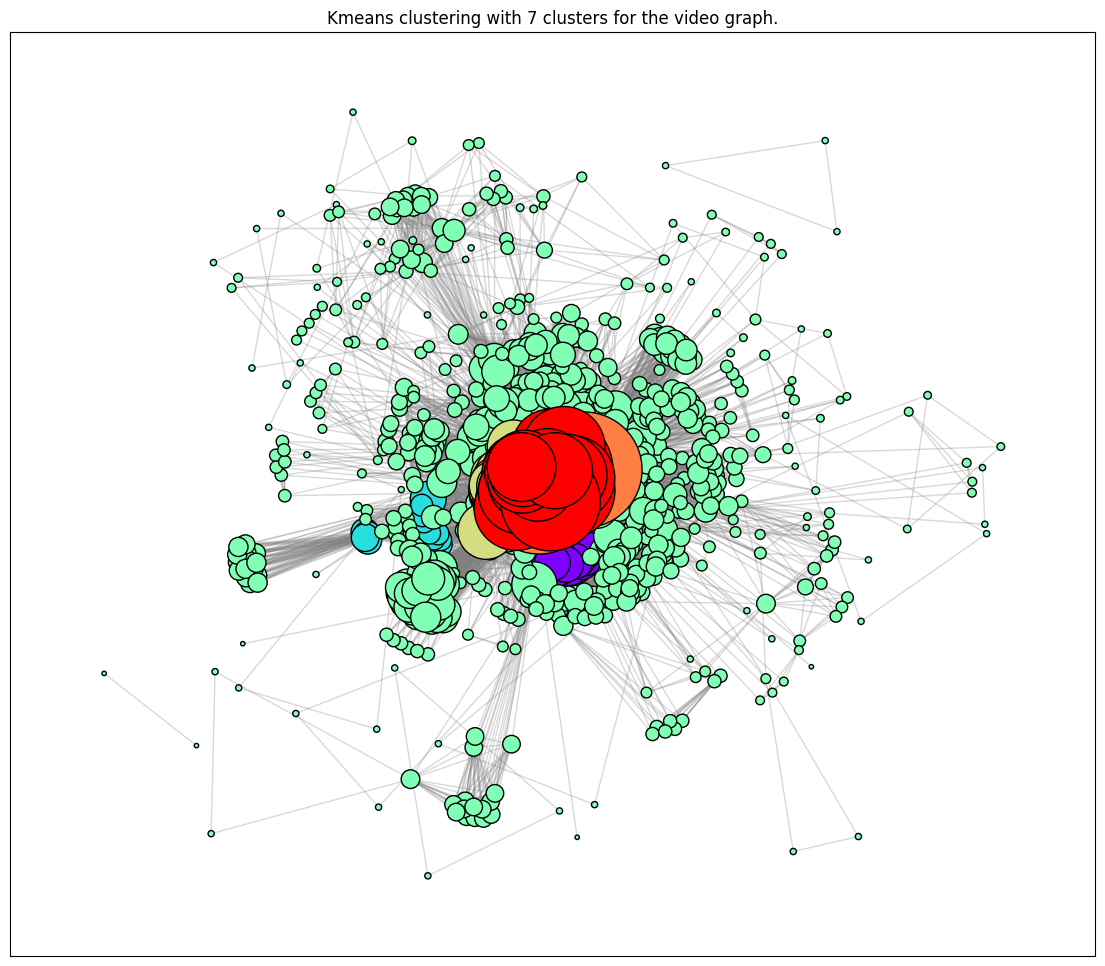

In [ ]:
title_kmeans = f'Kmeans clustering with {n_kmeans} clusters for the video graph.'
draw_clusters(G,kmeans_labels,n_kmeans,title_kmeans)

We can visually notice a clustering of nodes with close degree values together.

Now, `agglomerative clustering`. Let's observe the results:

Text(0.5, 1.0, 'Silouhette method')

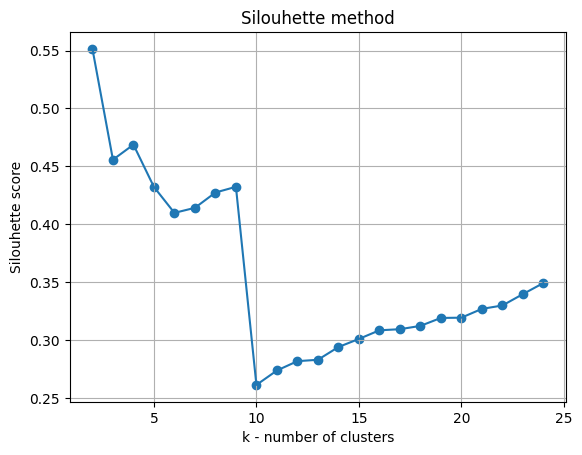

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, ClusterWarning
import warnings
warnings.filterwarnings("ignore", category=ClusterWarning)

scrs = []
linkage_type = 'ward'
A = nx.adjacency_matrix(G).todense()
for i in range(2,25):
    linkage_ = AgglomerativeClustering(n_clusters=i, metric='euclidean', linkage=linkage_type)
    linkage_.fit(A)
    scrs.append(silhouette_score(A,linkage_.labels_))
plt.scatter(range(2,25),scrs)
plt.plot(range(2,25),scrs)
plt.xlabel('k - number of clusters')
plt.ylabel('Silouhette score')
plt.grid(True)
plt.title('Silouhette method')

We will go with 4 clusters.

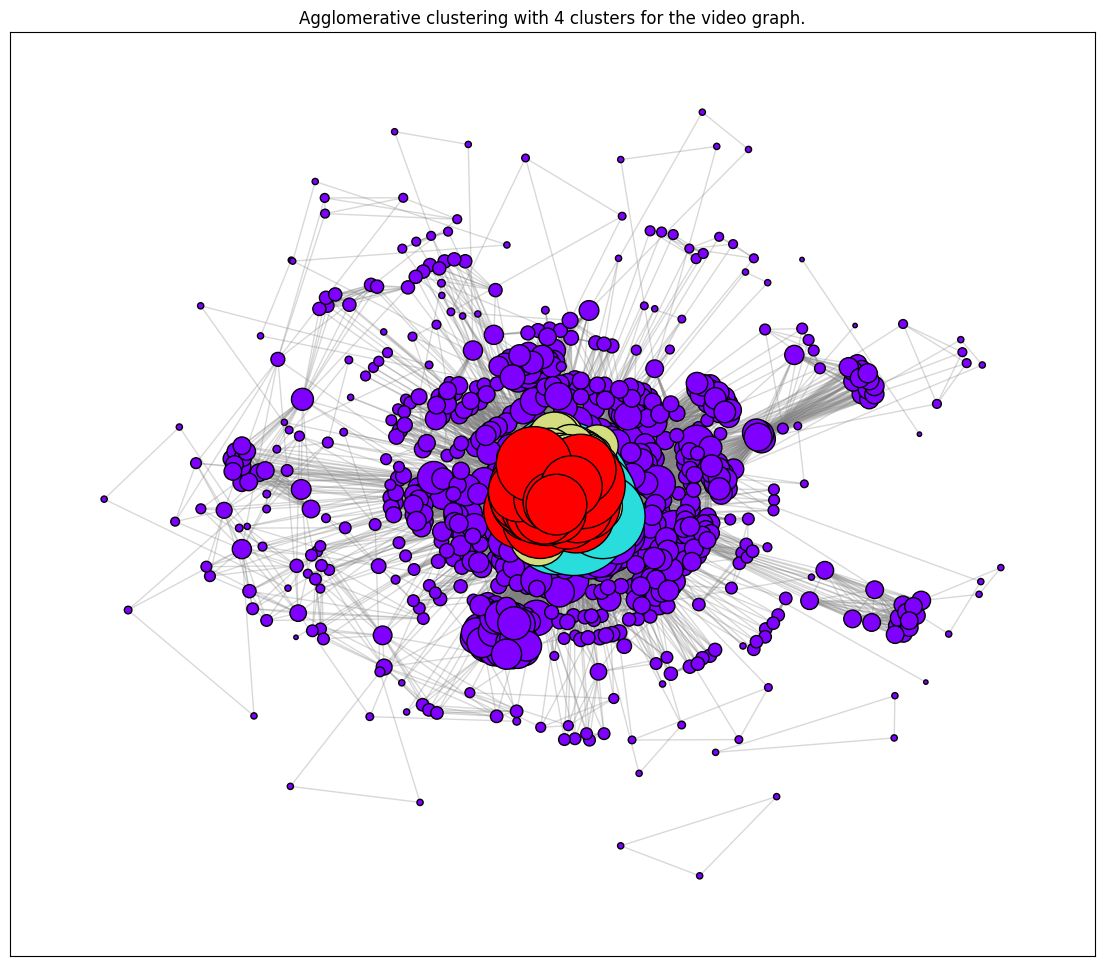

In [ ]:
n_agg = 4
linkage_ = AgglomerativeClustering(n_clusters=n_agg, metric='euclidean', linkage=linkage_type)
linkage_.fit(A)
agg_labels = linkage_.labels_
title_agg = f'Agglomerative clustering with {n_agg} clusters for the video graph.'
draw_clusters(G,agg_labels,n_agg, title_agg, attr='agglomerative_cluster')

Again, we notice that the nodes have been clustered based on popularity and frequency of occurence in videos, whith the central region of the graph being more dense with the most popular tags. Also, it seems agglomerative clustering gives a more visually-appealing partition of nodes that goes from the outer limits of the network to the center.

#### Community detection

Let us try the Louvain method for community detection, which is a widely used heuristic for this purpose. It operates on the principle of maximizing modularity, a metric that measures the strength of division of a network into modules or communities.

In [ ]:
def expected_edges(A, m):
    ee = np.zeros(A.shape)
    n, _ = A.shape
    for i in range(n):
        for j in range(n):
            a = np.sum(A[i,:])
            b = np.sum(A[j,:])
            ee[i,j] = a*b/(2*m)
    return ee

In [ ]:
def modularity_gain(A, ee, mnode, old_comm, new_comm, m):
    n, _ = A.shape
    mod_g = np.zeros(n)
    M = A - ee
    for i in range(n):
        arr = M[i,:]
        mod_g[i] = np.sum(arr[new_comm]) - np.sum(arr[[k for k in old_comm if k!=i]])
    return mod_g[mnode]/m

In [ ]:
def unfolded_communities(G):
    A = nx.to_numpy_array(G)
    m = A.sum() / 2
    ee = expected_edges(A, m)
    mapping = {node:i for i,node in enumerate(G.nodes)}
    communities = [[mapping[n]] for n in G.nodes]
    max_modularity_gain = 1
    while max_modularity_gain > 0:
        tot_gain = 0
        for node in G.nodes:
            print(f'Node: {mapping[node]}')
            if mapping[node] in communities[mapping[node]]:
                communities[mapping[node]].remove(mapping[node])
                max_gain_idx = mapping[node]
                max_gain = 0
                for i in range(len(communities)):
                    if i != mapping[node]:
                        gain = modularity_gain(A, ee, mapping[node], communities[mapping[node]], communities[i], m)
                        if gain > max_gain:
                            max_gain = gain
                            max_gain_idx = i

                communities[max_gain_idx].append(mapping[node])
                tot_gain += max_gain

        max_modularity_gain = tot_gain
        print(communities)
        print(f'Max modularity gain: {max_modularity_gain}')
    return [c for c in communities if len(c)]

The algorithm is too heavy with the size of the graph in this project, therefore I will share the results of the `unfolded_communities` function from a previous execution (took a while):

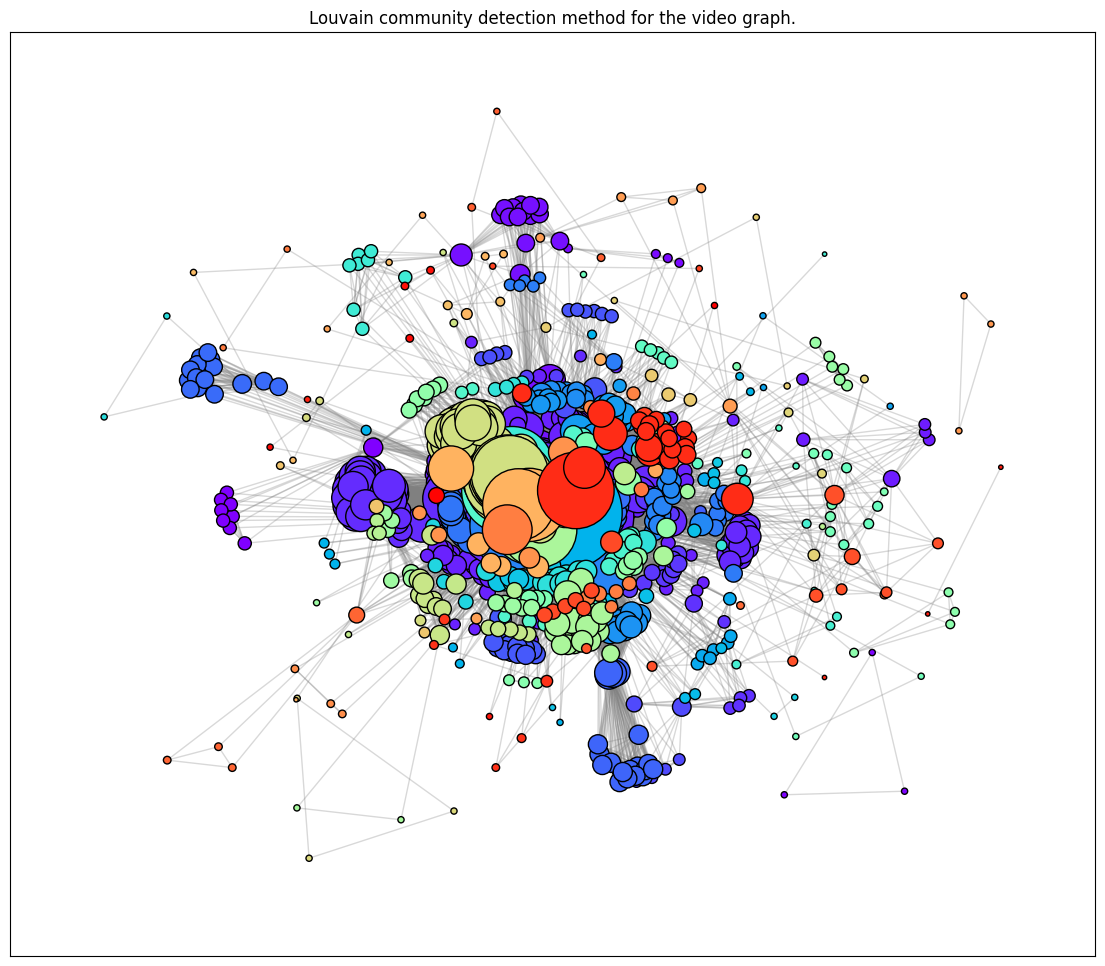


 Number of communities identified: 138


In [ ]:
iterG = G.copy()
#communities = unfolded_communities(iterG)
communities = [[3, 190, 252, 494, 572, 718, 759, 962, 22], [17, 682, 23], [9, 707, 950, 24], [26, 31, 37, 116, 158, 310, 314, 462, 533, 549, 555, 731, 859, 907, 955, 990, 27], [2, 32, 41, 50, 104, 114, 118, 136, 152, 154, 155, 169, 173, 187, 191, 214, 216, 222, 224, 234, 250, 266, 271, 275, 283, 290, 293, 298, 299, 303, 312, 315, 320, 323, 328, 331, 333, 347, 358, 367, 378, 380, 381, 388, 395, 398, 403, 404, 408, 423, 426, 431, 433, 440, 452, 463, 466, 474, 479, 493, 499, 510, 515, 520, 525, 527, 530, 531, 532, 534, 537, 545, 550, 552, 562, 566, 585, 592, 594, 595, 605, 610, 631, 633, 656, 659, 673, 675, 676, 688, 700, 703, 709, 713, 716, 722, 723, 738, 739, 750, 752, 757, 778, 779, 785, 793, 796, 815, 816, 820, 822, 831, 839, 844, 851, 865, 870, 871, 879, 880, 883, 900, 902, 909, 914, 925, 931, 941, 951, 966, 968, 985, 988, 992, 998, 1002, 1004, 1007, 1011, 1012, 1026, 1030, 1033, 28], [19, 301, 305, 657, 813, 29], [38, 70, 97, 111, 122, 171, 198, 204, 220, 221, 228, 238, 242, 244, 253, 254, 294, 325, 339, 352, 353, 361, 366, 368, 383, 415, 425, 444, 467, 471, 483, 489, 500, 503, 513, 526, 543, 558, 567, 570, 575, 607, 616, 626, 640, 642, 654, 689, 692, 717, 726, 727, 729, 732, 736, 737, 761, 773, 781, 786, 806, 809, 812, 817, 819, 828, 841, 846, 849, 856, 867, 873, 878, 897, 903, 908, 911, 936, 954, 963, 970, 971, 978, 980, 991, 996, 1003, 1017, 1034, 1035, 1038, 1039, 1040, 86, 140, 202, 359, 369, 599, 833, 981, 43], [34, 141, 232, 385, 407, 451, 458, 465, 487, 512, 582, 627, 762, 766, 797, 850, 862, 928, 961, 1041, 47], [5, 57, 63, 109, 138, 167, 172, 178, 223, 255, 259, 260, 261, 319, 321, 327, 341, 348, 356, 375, 386, 387, 393, 402, 447, 455, 473, 508, 557, 597, 600, 612, 635, 637, 645, 650, 652, 665, 733, 735, 777, 787, 794, 861, 892, 894, 898, 912, 916, 927, 959, 1016, 1019, 51], [21, 117, 197, 783, 808, 62], [30, 94, 235, 394, 396, 492, 617, 662, 710, 740, 741, 789, 854, 888, 905, 80], [40, 219], [58, 101, 112, 125, 183, 186, 205, 208, 251, 272, 277, 284, 480, 484, 488, 514, 541, 556, 564, 571, 576, 578, 580, 583, 609, 629, 632, 668, 677, 680, 690, 702, 712, 780, 814, 872, 895, 901, 910, 938, 947, 964, 974, 979, 986, 1006, 1022, 1036, 88], [12, 46, 518, 695, 742, 746, 89], [81, 345, 362, 687, 92], [93, 137, 156, 181, 825, 969, 95], [42, 279, 300, 304, 397, 496, 548, 604, 664, 708, 775, 798, 976, 135], [64], [36, 83, 162, 306, 350, 370, 421, 424, 436, 449, 450, 495, 507, 569, 613, 683, 696, 771, 997, 144], [44, 150, 199, 491, 504, 539, 560, 681, 701, 704, 719, 827, 886, 889, 893, 147], [77, 226, 287, 364, 505, 590, 149], [145, 217, 289, 344, 428, 469, 529, 624, 636, 919, 153], [107, 280, 540, 621, 653, 769, 840, 1001, 166], [73, 400, 691, 791, 948, 168], [6, 18, 53, 100, 296, 410, 419, 427, 634, 725, 896, 943, 174], [119, 329, 472, 643, 764, 904, 1028, 179], [75, 326, 336, 497, 586, 639, 935, 975, 182], [49, 195, 297, 443, 470, 523, 618, 715, 795, 887, 967, 993, 185], [39, 248, 422, 755, 843, 920, 192], [67, 346, 351, 373, 441, 453, 460, 516, 584, 591, 663, 754, 810, 845, 977, 1020, 193], [165, 194], [105], [163, 399, 698, 868, 876, 1042, 201], [127], [14, 65, 372, 416, 852, 944, 958, 1027, 207], [151, 212], [7, 170, 853, 995, 213], [121, 568, 863, 215], [203], [96, 536, 606, 647, 869, 942, 225], [128], [15, 35], [126, 229], [142, 406, 949, 237], [10], [59], [13, 249], [257, 274, 317, 401, 542, 596, 651, 660, 670, 770, 858, 937, 258], [146, 432, 744, 264], [175, 953, 268], [90], [263, 308, 340, 355, 630, 661, 885, 956, 278], [231, 282], [130, 357, 705, 286], [188], [239, 335, 379, 501, 714, 724, 765, 1024, 295], [8], [25, 54, 55, 623, 855, 945, 311], [148, 924], [134, 365], [189], [79, 442, 602, 899, 382], [113], [377, 684, 721, 1010, 390], [176], [245, 405], [206, 437, 486, 414], [72], [281, 824, 999, 434], [354, 435], [91], [291, 832, 461], [445, 917, 1043, 476], [227, 528, 559, 589, 747, 799, 482], [48, 324, 611, 697, 830, 987, 485], [288, 577, 767, 768, 884, 502], [60, 66, 267, 573, 847, 972, 509], [159, 679, 811, 1008, 1032, 517], [384], [302, 538], [0, 103, 139, 210, 211, 233, 243, 247, 273, 307, 334, 337, 371, 430, 490, 563, 608, 615, 628, 658, 678, 711, 751, 829, 838, 965, 544], [102], [76], [241, 734, 551], [87], [164], [218], [292, 743, 784, 922, 1000, 581], [448, 641, 758, 802, 881, 913, 930, 983, 1013, 587], [108, 363], [52, 78, 82, 84, 85, 110, 115, 120, 129, 133, 180, 200, 246, 262, 270, 313, 322, 332, 338, 342, 360, 374, 376, 413, 417, 420, 429, 459, 475, 478, 498, 524, 535, 553, 561, 579, 593, 601, 620, 622, 648, 667, 674, 720, 753, 756, 760, 776, 790, 792, 801, 803, 805, 821, 823, 834, 848, 860, 882, 891, 906, 918, 921, 923, 929, 932, 934, 940, 960, 982, 1021, 1029, 603], [318], [265, 619], [71, 946, 638], [522, 644], [230, 236, 646], [160, 837, 666], [276, 412, 669], [614], [20, 685], [240, 686], [1, 1014, 693], [45, 418, 694], [98, 123, 131, 132, 269, 547, 749, 730], [33], [143], [625, 745], [588], [316, 391, 866, 1005, 763], [468, 874, 772], [4, 99, 343, 782], [439, 984, 804], [481], [565], [56, 409, 438, 672, 926, 818], [177, 826], [209], [774], [330], [184, 392, 1023, 857], [671, 699, 877], [890], [915], [68, 157, 454, 457, 807, 836, 1037, 933], [256, 285, 309, 554, 649, 655, 939], [196, 952], [124], [875], [411, 598, 842, 989], [11, 74, 161, 349, 389, 446, 456, 477, 506, 511, 519, 521, 546, 574, 728, 788, 800, 864, 957, 973, 1018, 1031, 994], [106], [464], [748, 1009], [16], [706, 1015], [69, 1025], [61], [835]]
labels_louvain = np.zeros(len(G), dtype=int)
for i, c in enumerate(communities):
    labels_louvain[c] = i
n_louvain = len(set(labels_louvain))
title_louvain = f'Louvain community detection method for the video graph.'
draw_clusters(G,labels_louvain,n_louvain, title_=title_louvain, attr='louvain_method')
print(f'\n Number of communities identified: {n_louvain}')

We can firstly see that communities don't seem to be mainly degree related, like in the 2 previous clustering methods, since it's based on the `modularity` metric's gains.<br>
We can notice a large number of communities (`138`): central ones contain larger nodes, indicating core communities with high-degree hashtags, while those away from the center show smaller less connected communities.<br>
So, in conclusion, the graph presents a `highly modular structure`, reflecting the diversity of the topic of interest of the network, cryptocurrency.